In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2                                      
%matplotlib inline       
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator               
from tqdm import tqdm


2022-11-28 18:27:07.774401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

In [5]:
len(train_targets)

6680

In [13]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

In [14]:
## find the list of labels and save them as a pandas data 
labels_train = []
labels_test = []

for i in range(train_files.shape[0]):
    labels_train.append(dog_names[np.argmax(train_targets[i])])
    
for i in range(test_files.shape[0]):
    labels_test.append(dog_names[np.argmax(test_targets[i])])

# CNN model from scratch


### Pre-process the Data
When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

(nb_samples,rows,columns,channels),
 
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is  224×224  pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

(1,224,224,3).
 
The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

(nb_samples,224,224,3).
 
Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [17]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale the images by dividing every pixel in every image by 255.

In [19]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 836/836 [00:05<00:00, 155.96it/s]


In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

# architucture

# layer 1
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))

# layer 2
model.add(Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))

# layer 3
model.add(Conv2D(filters=64, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))

# layer 4
model.add(Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

# layer 5
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

# 2 fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133,activation='softmax'))

model.summary()

2022-11-27 17:02:02.576497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

### Compile the Model

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
from keras.callbacks import ModelCheckpoint  


epochs = 30


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/30
334/334 [==============================] - ETA: 0s - loss: 4.8785 - accuracy: 0.0123
Epoch 1: val_loss improved from inf to 4.79596, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 151s 448ms/step - loss: 4.8785 - accuracy: 0.0123 - val_loss: 4.7960 - val_accuracy: 0.0180
Epoch 2/30
334/334 [==============================] - ETA: 0s - loss: 4.6784 - accuracy: 0.0256
Epoch 2: val_loss improved from 4.79596 to 4.53538, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 146s 436ms/step - loss: 4.6784 - accuracy: 0.0256 - val_loss: 4.5354 - val_accuracy: 0.0335
Epoch 3/30
334/334 [==============================] - ETA: 0s - loss: 4.4151 - accuracy: 0.0463
Epoch 3: val_loss improved from 4.53538 to 4.28848, saving model to saved_models/weights.best.from_scratch.hdf5
334/334 [==============================] - 145s 433ms/step - loss: 4.4151 - accuracy: 0.0463 - val_loss: 4.288

Epoch 28/30
334/334 [==============================] - ETA: 0s - loss: 2.1762 - accuracy: 0.4409
Epoch 28: val_loss did not improve from 3.62333
334/334 [==============================] - 131s 393ms/step - loss: 2.1762 - accuracy: 0.4409 - val_loss: 3.7084 - val_accuracy: 0.1377
Epoch 29/30
334/334 [==============================] - ETA: 0s - loss: 2.1467 - accuracy: 0.4584
Epoch 29: val_loss did not improve from 3.62333
334/334 [==============================] - 124s 373ms/step - loss: 2.1467 - accuracy: 0.4584 - val_loss: 3.6495 - val_accuracy: 0.1653
Epoch 30/30
334/334 [==============================] - ETA: 0s - loss: 2.1164 - accuracy: 0.4590
Epoch 30: val_loss did not improve from 3.62333
334/334 [==============================] - 134s 402ms/step - loss: 2.1164 - accuracy: 0.4590 - val_loss: 3.8468 - val_accuracy: 0.1186


In [24]:
model.save('saved_models/cnn_model.h5')

### Load the Model with the Best Validation Loss

In [25]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the model

In [26]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step
Test accuracy: 15.3110%


### Data Augmentation

In [118]:
## data augmentation
from keras.preprocessing.image import ImageDataGenerator

## create a generator that rotate, zoom and flip the images
traingen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1/255,
        shear_range=0.04,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip= False,
        fill_mode='nearest')
validgen = ImageDataGenerator(rescale=1/255)

## apply the generator on test and valid sets
traingen.fit(train_tensors)
validgen.fit(valid_tensors)

df_training = traingen.flow(train_tensors , train_targets , batch_size = 20)
df_validation = validgen.flow(valid_tensors , valid_targets, batch_size = 20)

In [119]:
from keras.optimizers import Adam
model.compile(optimizer= Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [120]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.initial_scratch_model_aug.hdf5', verbose = 0, save_best_only=True)
model.fit_generator(df_training, epochs = 25 , steps_per_epoch = train_tensors.shape[0]//32 , 
                   callbacks=[checkpointer] , verbose=1 , 
                   validation_data= df_validation , validation_steps = valid_tensors.shape[0]//32)

/var/folders/5c/_m6k74_557zg9wwfqkptf4540000gn/T/ipykernel_37599/814489786.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(df_training, epochs = 25 , steps_per_epoch = train_tensors.shape[0]//32 ,


Epoch 1/25
208/208 [==============================] - 109s 521ms/step - loss: 4.9428 - accuracy: 0.0075 - val_loss: 4.9024 - val_accuracy: 0.0077
Epoch 2/25
208/208 [==============================] - 101s 483ms/step - loss: 4.8863 - accuracy: 0.0113 - val_loss: 4.8863 - val_accuracy: 0.0115
Epoch 3/25
208/208 [==============================] - 100s 478ms/step - loss: 4.8832 - accuracy: 0.0089 - val_loss: 4.8668 - val_accuracy: 0.0115
Epoch 4/25
208/208 [==============================] - 100s 481ms/step - loss: 4.8820 - accuracy: 0.0096 - val_loss: 4.8740 - val_accuracy: 0.0115
Epoch 5/25
208/208 [==============================] - 96s 459ms/step - loss: 4.8784 - accuracy: 0.0075 - val_loss: 4.8747 - val_accuracy: 0.0038
Epoch 6/25
208/208 [==============================] - 100s 479ms/step - loss: 4.8733 - accuracy: 0.0113 - val_loss: 4.8756 - val_accuracy: 0.0096
Epoch 7/25
208/208 [==============================] - 102s 488ms/step - loss: 4.8735 - accuracy: 0.0099 - val_loss: 4.8709 - 

In [121]:
## strangeley, the data augmenation accuracy becomes lower than original data. It usually causes overfitting, but in my case it is underfitting.
## need to work more on the generator 
dog_breed_predictions_aug = [np.argmax(model.predict(np.expand_dims(tensor, axis = 0))) for tensor in test_tensors]

test_accuracy_aug = 100*np.sum(np.array(dog_breed_predictions_aug)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions_aug)
print('Test accuracy with Data Augmentation: %.f%%' % test_accuracy_aug)


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 34ms/step
Test accuracy with Data Augmentation: 1%


## Creating CNN-models to Classify Dog Breeds using Transfer Learning

We use the bottleneck features from a different pre-trained model. We have downloaded the pre-computed features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features


In [27]:
def other_bottleneck_features(path):
    bottleneck_features = np.load(path)
    train = bottleneck_features['train'] 
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']
    return train,valid,test

# VGG19 model

In [28]:
train_VGG19 , valid_VGG19, test_VGG19 = other_bottleneck_features('bottleneck_features/DogVGG19Data.npz')

In [29]:
#VGG19 architecture
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=(train_VGG19.shape[1:])))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [30]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [31]:
### Training  the model.
checkpointer_VGG19 = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', verbose=1 , save_best_only =True)

VGG19_model.fit(train_VGG19, train_targets,
                  validation_data = (valid_VGG19 , valid_targets),
                  epochs=25, batch_size=20, callbacks=[checkpointer_VGG19], verbose=1)

Epoch 1/25
321/334 [===========================>..] - ETA: 0s - loss: 7.2027 - accuracy: 0.2441
Epoch 1: val_loss improved from inf to 3.03797, saving model to saved_models/weights.best.VGG19.hdf5
334/334 [==============================] - 2s 3ms/step - loss: 7.0376 - accuracy: 0.2537 - val_loss: 3.0380 - val_accuracy: 0.4874
Epoch 2/25
332/334 [============================>.] - ETA: 0s - loss: 1.8806 - accuracy: 0.6322
Epoch 2: val_loss improved from 3.03797 to 2.25496, saving model to saved_models/weights.best.VGG19.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 1.8767 - accuracy: 0.6329 - val_loss: 2.2550 - val_accuracy: 0.5976
Epoch 3/25
312/334 [===========================>..] - ETA: 0s - loss: 1.0492 - accuracy: 0.7641
Epoch 3: val_loss improved from 2.25496 to 2.08853, saving model to saved_models/weights.best.VGG19.hdf5
334/334 [==============================] - 1s 2ms/step - loss: 1.0545 - accuracy: 0.7647 - val_loss: 2.0885 - val_accuracy: 0.6311
Epoch 4/

In [32]:
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

In [33]:
VGG19_model.save('saved_models/VGG19_model.h5')

In [34]:
# a function that returns the prediction accuracy on test data
def evaluate_model (model, model_name,tensors,targets):
    predicted = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in tensors]
    test_accuracy = 100*np.sum(np.array(predicted)==np.argmax(targets, axis=1))/len(predicted)
    
    print (f'{model_name} accuracy on test data is {test_accuracy}%') 

In [35]:
evaluate_model(VGG19_model,"VGG19", test_VGG19, test_targets)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
VGG19 accuracy on test data is 70.33492822966507%


In [36]:
def extract_VGG19(tensor):
    from keras.applications.vgg19 import VGG19, preprocess_input
    return VGG19(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [40]:
def VGG19_predict_breed (img_path):
    # extract the bottle neck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path)) 
    ## get a vector of predicted values
    predicted_vector = VGG19_model.predict(bottleneck_feature) 
    
    ## return the breed
    return dog_names[np.argmax(predicted_vector)]

In [79]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

def breed_identifier_vgg19(img_path):
    display_img(img_path)
    prediction = VGG19_predict_breed(img_path)
    return print (f"This dog is a {prediction}\n")

1/1 [==============================] - 0s 19ms/step
This dog is a Curly-coated_retriever



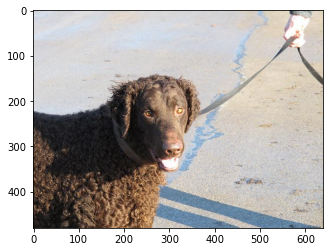

In [108]:
breed_identifier_vgg19('dogImages/test/055.Curly-coated_retriever/Curly-coated_retriever_03887.jpg')


1/1 [==============================] - 0s 18ms/step
This dog is a American_water_spaniel



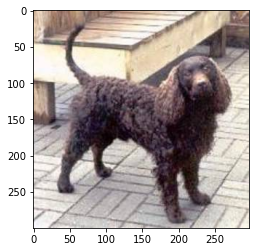

In [117]:
breed_identifier_vgg19('dogImages/test/009.American_water_spaniel/American_water_spaniel_00646.jpg')

# Resnet50 model

In [45]:
### Obtain bottleneck features from another pre-trained CNN.
train_Resnet50 , valid_Resnet50, test_Resnet50 = other_bottleneck_features('bottleneck_features/DogResnet50Data.npz')

In [46]:
### Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=(train_Resnet50.shape[1:])))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [49]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [50]:
### Train the model.
checkpointer_Resnet50 = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', verbose=1 , save_best_only =True)

Resnet50_model.fit(train_Resnet50, train_targets,
                  validation_data = (valid_Resnet50 , valid_targets),
                  epochs=25, batch_size=20, callbacks=[checkpointer_Resnet50], verbose=1)

Epoch 1/25
327/334 [============================>.] - ETA: 0s - loss: 0.1900 - accuracy: 0.9410
Epoch 1: val_loss improved from inf to 0.69426, saving model to saved_models/weights.best.Resnet50.hdf5
334/334 [==============================] - 2s 4ms/step - loss: 0.1903 - accuracy: 0.9413 - val_loss: 0.6943 - val_accuracy: 0.8060
Epoch 2/25
332/334 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9592
Epoch 2: val_loss did not improve from 0.69426
334/334 [==============================] - 1s 3ms/step - loss: 0.1262 - accuracy: 0.9590 - val_loss: 0.7122 - val_accuracy: 0.7964
Epoch 3/25
327/334 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9732
Epoch 3: val_loss improved from 0.69426 to 0.67055, saving model to saved_models/weights.best.Resnet50.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 0.0928 - accuracy: 0.9731 - val_loss: 0.6705 - val_accuracy: 0.8228
Epoch 4/25
329/334 [============================>.] - ETA: 0

In [51]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [52]:
evaluate_model(Resnet50_model,"Resnet50", test_Resnet50, test_targets)

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Resnet50 accuracy on test data is 80.98086124401914%


### Fine-tuning the Resnet50 model

In [53]:
from keras.optimizers import SGD

Resnet50_model_fine = Sequential()
Resnet50_model_fine.add(GlobalAveragePooling2D(input_shape=(train_Resnet50.shape[1:])))
Resnet50_model_fine.add(Dense(133, activation='softmax'))


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', verbose = 0, save_best_only=True)

sgd = SGD(lr= 1e-3 , decay=1e-6, momentum=0.9 , nesterov = True)

# compile 
Resnet50_model_fine.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


Resnet50_model_fine.fit(train_Resnet50 , train_targets, 
               validation_data = (valid_Resnet50, valid_targets),
               shuffle = True,
               batch_size = 20,
               epochs = 25,
               verbose = 1)

Epoch 1/25


/Users/vaishakkallampad/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


334/334 [==============================] - 1s 3ms/step - loss: 3.0047 - accuracy: 0.3876 - val_loss: 1.7109 - val_accuracy: 0.6204
Epoch 2/25
334/334 [==============================] - 1s 2ms/step - loss: 1.2050 - accuracy: 0.7496 - val_loss: 1.1011 - val_accuracy: 0.7521
Epoch 3/25
334/334 [==============================] - 1s 2ms/step - loss: 0.7988 - accuracy: 0.8347 - val_loss: 0.9056 - val_accuracy: 0.7689
Epoch 4/25
334/334 [==============================] - 1s 2ms/step - loss: 0.6175 - accuracy: 0.8740 - val_loss: 0.7989 - val_accuracy: 0.7952
Epoch 5/25
334/334 [==============================] - 1s 2ms/step - loss: 0.5071 - accuracy: 0.8987 - val_loss: 0.7445 - val_accuracy: 0.7976
Epoch 6/25
334/334 [==============================] - 1s 2ms/step - loss: 0.4327 - accuracy: 0.9174 - val_loss: 0.7027 - val_accuracy: 0.8024
Epoch 7/25
334/334 [==============================] - 1s 2ms/step - loss: 0.3789 - accuracy: 0.9338 - val_loss: 0.6683 - val_accuracy: 0.8180
Epoch 8/25
334/33

In [54]:
evaluate_model(Resnet50_model_fine, "fine_tuned Resnet50" , test_Resnet50, test_targets)
Resnet50_model_fine.save('saved_models/Resnet50_model_fine.h5')

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
fine_tuned Resnet50 accuracy on test data is 83.2535885167464%


In [55]:
def extract_Resnet50(tensor):
    from keras.applications.resnet import ResNet50, preprocess_input
    return ResNet50(weights='imagenet', pooling="avg", include_top=False).predict(preprocess_input(tensor))

In [63]:
def Resnet50_predict_breed (img_path):
   #extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    #obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature) #shape error occurs here
    #return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [77]:
def breed_identifier_resnet50(img_path):
    display_img(img_path)
    prediction = Resnet50_predict_breed(img_path)
    return print (f"This dog is a {prediction}\n")


1/1 [==============================] - 0s 21ms/step
This dog is a Curly-coated_retriever



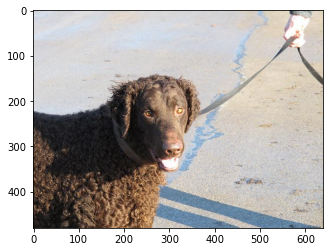

In [109]:
breed_identifier_resnet50('dogImages/test/055.Curly-coated_retriever/Curly-coated_retriever_03887.jpg')


1/1 [==============================] - 0s 16ms/step
This dog is a American_water_spaniel



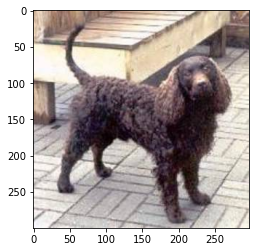

In [116]:
breed_identifier_resnet50('dogImages/test/009.American_water_spaniel/American_water_spaniel_00646.jpg')

# InceptionV3 model

In [68]:
train_Inception , valid_Inception, test_Inception = other_bottleneck_features('bottleneck_features/DogInceptionV3Data.npz')

In [69]:
### Define your architecture.
Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=(train_Inception.shape[1:])))
Inception_model.add(Dense(133, activation='softmax'))

Inception_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [70]:
Inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [71]:
### Train the model.
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer_Inception = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', verbose=1 , save_best_only =True)

Inception_model.fit(train_Inception, train_targets,
                  validation_data = (valid_Inception , valid_targets),
                  epochs=30, batch_size=20, callbacks=[checkpointer_Inception], verbose=1)

Epoch 1/30
323/334 [============================>.] - ETA: 0s - loss: 1.1827 - accuracy: 0.7042
Epoch 1: val_loss improved from inf to 0.64099, saving model to saved_models/weights.best.Inception.hdf5
334/334 [==============================] - 3s 7ms/step - loss: 1.1709 - accuracy: 0.7066 - val_loss: 0.6410 - val_accuracy: 0.8263
Epoch 2/30
327/334 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.8534
Epoch 2: val_loss improved from 0.64099 to 0.62164, saving model to saved_models/weights.best.Inception.hdf5
334/334 [==============================] - 2s 5ms/step - loss: 0.4798 - accuracy: 0.8528 - val_loss: 0.6216 - val_accuracy: 0.8323
Epoch 3/30
318/334 [===========================>..] - ETA: 0s - loss: 0.3663 - accuracy: 0.8866
Epoch 3: val_loss did not improve from 0.62164
334/334 [==============================] - 1s 4ms/step - loss: 0.3662 - accuracy: 0.8873 - val_loss: 0.6257 - val_accuracy: 0.8383
Epoch 4/30
322/334 [===========================>..] - ETA:

In [72]:
Inception_model.load_weights('saved_models/weights.best.Inception.hdf5')

In [73]:
Inception_model.save('saved_models/Inception.h5')

In [74]:
###  Calculate classification accuracy on the test dataset.
evaluate_model(Inception_model,"InceptionV3", test_Inception, test_targets)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
InceptionV3 accuracy on test data is 77.87081339712918%


In [83]:
def extract_Inception(tensor):
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [84]:
def Inception_predict_breed (img_path):
    # extract the bottle neck features
    bottleneck_feature = extract_Inception(path_to_tensor(img_path)) 
    ## get a vector of predicted values
    predicted_vector = Inception_model.predict(bottleneck_feature) 
    
    ## return the breed
    return dog_names[np.argmax(predicted_vector)]

In [85]:
def breed_identifier_inceptionv3(img_path):
    display_img(img_path)
    prediction = Inception_predict_breed(img_path)
    print('picture is a dog')
    return print (f"This dog is a {prediction}\n")

1/1 [==============================] - 0s 23ms/step
picture is a dog
This dog is a Curly-coated_retriever



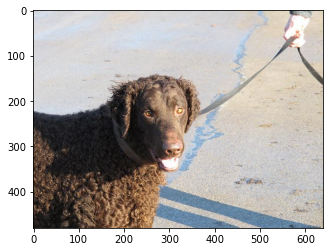

In [110]:
breed_identifier_inceptionv3('dogImages/test/055.Curly-coated_retriever/Curly-coated_retriever_03887.jpg')

1/1 [==============================] - 0s 19ms/step
picture is a dog
This dog is a American_water_spaniel



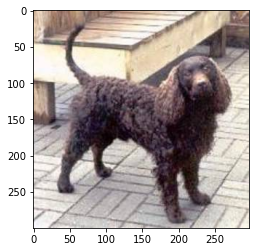

In [115]:
breed_identifier_inceptionv3('dogImages/test/009.American_water_spaniel/American_water_spaniel_00646.jpg')

# Xception model

In [88]:
### Obtain bottleneck features from another pre-trained CNN.
train_Xception , valid_Xception, test_Xception = other_bottleneck_features('bottleneck_features/DogXceptionData.npz')

In [89]:
### Define your architecture.
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=(train_Xception.shape[1:])))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [90]:
### Compile the model.
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [91]:
### Train the model.
checkpointer_Xception = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', verbose=1 , save_best_only =True)

Xception_history = Xception_model.fit(train_Xception, train_targets,
                  validation_data = (valid_Xception , valid_targets),
                  epochs=25, batch_size=20, callbacks=[checkpointer_Xception], verbose=1)

Epoch 1/25
332/334 [============================>.] - ETA: 0s - loss: 1.0621 - accuracy: 0.7389
Epoch 1: val_loss improved from inf to 0.51711, saving model to saved_models/weights.best.Xception.hdf5
334/334 [==============================] - 3s 8ms/step - loss: 1.0593 - accuracy: 0.7392 - val_loss: 0.5171 - val_accuracy: 0.8263
Epoch 2/25
323/334 [============================>.] - ETA: 0s - loss: 0.3921 - accuracy: 0.8769
Epoch 2: val_loss improved from 0.51711 to 0.48844, saving model to saved_models/weights.best.Xception.hdf5
334/334 [==============================] - 2s 5ms/step - loss: 0.3975 - accuracy: 0.8756 - val_loss: 0.4884 - val_accuracy: 0.8407
Epoch 3/25
325/334 [============================>.] - ETA: 0s - loss: 0.3125 - accuracy: 0.9023
Epoch 3: val_loss improved from 0.48844 to 0.46664, saving model to saved_models/weights.best.Xception.hdf5
334/334 [==============================] - 2s 5ms/step - loss: 0.3151 - accuracy: 0.9012 - val_loss: 0.4666 - val_accuracy: 0.8539

In [92]:
### Load the model weights with the best validation loss.
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

In [93]:
Xception_model.save('saved_models/Xception_model.h5')

In [94]:
# a function that returns the prediction accuracy on test data
def evaluate_model (model, model_name,tensors,targets):
    predicted = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in tensors]
    test_accuracy = 100*np.sum(np.array(predicted)==np.argmax(targets, axis=1))/len(predicted)
    
    print (f'{model_name} accuracy on test data is {test_accuracy}%') 

In [95]:
###  Calculate classification accuracy on the test dataset.
evaluate_model(Xception_model, "Xception" , test_Xception, test_targets)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
Xception accuracy on test data is 85.04784688995215%


### Fine-tuning the Xception model

In [96]:
## finetuned the Exception model by minimizing the cross-entropy loss function using stochastic gradient descent 
## and learning rate of 0.001

Xception_model_aug = Sequential()
Xception_model_aug.add(GlobalAveragePooling2D(input_shape=(train_Xception.shape[1:])))
# Xception_model_aug.add(BatchNormalization())
Xception_model_aug.add(Dense(133, activation='softmax'))


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', verbose = 0, save_best_only=True)

sgd = SGD(lr= 1e-3 , decay=1e-6, momentum=0.9 , nesterov = True)

# compile 
Xception_model_aug.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


Xception_model_aug.fit(train_Xception , train_targets, 
               validation_data = (valid_Xception, valid_targets),
               shuffle = True,
               batch_size = 20,
               epochs = 25,
               verbose = 1)

Epoch 1/25
334/334 [==============================] - 2s 6ms/step - loss: 3.9090 - accuracy: 0.3305 - val_loss: 2.8550 - val_accuracy: 0.6108
Epoch 2/25
334/334 [==============================] - 1s 4ms/step - loss: 2.1539 - accuracy: 0.6931 - val_loss: 1.7147 - val_accuracy: 0.7401
Epoch 3/25
334/334 [==============================] - 1s 3ms/step - loss: 1.3719 - accuracy: 0.7805 - val_loss: 1.2341 - val_accuracy: 0.7653
Epoch 4/25
334/334 [==============================] - 1s 3ms/step - loss: 1.0236 - accuracy: 0.8229 - val_loss: 1.0010 - val_accuracy: 0.7988
Epoch 5/25
334/334 [==============================] - 1s 3ms/step - loss: 0.8414 - accuracy: 0.8451 - val_loss: 0.8698 - val_accuracy: 0.8156
Epoch 6/25
334/334 [==============================] - 1s 4ms/step - loss: 0.7287 - accuracy: 0.8609 - val_loss: 0.7830 - val_accuracy: 0.8263
Epoch 7/25
334/334 [==============================] - 1s 4ms/step - loss: 0.6539 - accuracy: 0.8723 - val_loss: 0.7227 - val_accuracy: 0.8371
Epoch 

In [97]:
Xception_model_aug.save('saved_models/Xception_model_aug.h5')

In [98]:
## with fine tuning the accuracy increased by almost 1.5% 
evaluate_model(Xception_model_aug, "fine_tuned Xception" , test_Xception, test_targets)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
fine_tuned Xception accuracy on test data is 85.16746411483254%


In [99]:
def extract_Xception(tensor):
    from keras.applications.xception import Xception, preprocess_input
    return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [100]:
### a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def Xception_predict_breed (img_path):
    # extract the bottle neck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path)) 
    ## get a vector of predicted values
    predicted_vector = Xception_model_aug.predict(bottleneck_feature) 
    
    ## return the breed
    return dog_names[np.argmax(predicted_vector)]

In [101]:
def breed_identifier_xception(img_path):
    display_img(img_path)
    prediction = Xception_predict_breed(img_path)
    print('picture is a dog')
    return print (f"This dog is a {prediction}\n")

1/1 [==============================] - 0s 21ms/step
picture is a dog
This dog is a Curly-coated_retriever



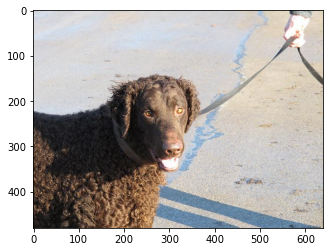

In [111]:
breed_identifier_xception('dogImages/test/055.Curly-coated_retriever/Curly-coated_retriever_03887.jpg')
                        

1/1 [==============================] - 0s 19ms/step
picture is a dog
This dog is a American_water_spaniel



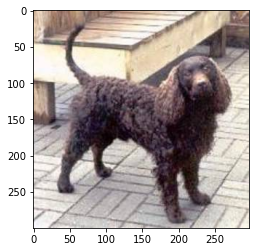

In [114]:
breed_identifier_xception('dogImages/test/009.American_water_spaniel/American_water_spaniel_00646.jpg')